# Nested workflows

* **Difficulty level**: intermediate
* **Time need to lean**: 10 minutes or less
* **Key points**:
  * Action `sos_run` execute a workflow
  * Multiple workflows can be executed in parallel if they are specified as a list to action `sos_run`
  

## Nested workflow

Function 

```python
sos_run(workflow=None, targets=None, shared=[], source=None, args={}, **kwargs)
```
executes a specified workflow from the current (default) or specified SoS script (`source`). The workflow can be a single workflow, a subworkflow (e.g. `A_-10`), a combined workflow (e.g. `A + B`), a workflow that is constructed to generate `targets`, or even a combination of both. The workflow

* Takes `_input` of the parental step as the input of the first step of the subworkflow
* Takes `args` (a dictionary) and `**kwargs` as parameters as if they are specified from command line
* Copies variables specified in `shared` (a string or a list of string) to the subworkflow if they exist in the parental namespace
* Returns variables defined in `shared` to the parental namespace after the completion of the workflow

## Specification of workflows

The workflow can be a single workflow, a combined or subworkflow as follows

```python
sos_run('A')            # execute workflow A
sos_run('A + B')        # execute workflow B after A
sos_run('D:-10 + C')    # execute up to step 10 of D and workflow C
```

Because only a string is needed, it could be constructed dynamically, for example, from user-specified parameters:

```python
sos_run(f'{aligner} + {caller}')  
```

In its simplest form, nested workflow allows you to define another workflow from existing ones. For example,

align_10


align_20


call_10


call_20


> forward.dot (2.1 KiB):

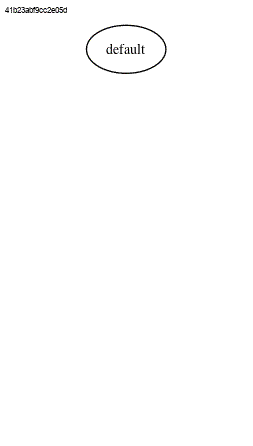

In [1]:
%preview -n forward.dot
%run -v1 -d forward.dot
[align_10]
print(step_name)
[align_20]
print(step_name)
[call_10]
print(step_name)
[call_20]
print(step_name)
[default]
sos_run('align+call')

defines a nested workflow that combines workflows `align` and `call` so that the workflow will by default execute two workflows, but can also execute one of them as separate workflows `align` and `call`. This example also uses option `-d` to output the execution path of the workflow to a file, and magic `%preview` to preview the path.

Nested workflow also allows you to define multiple mini-workflows and connect them freely. For example

```python
[a_1]
[a_2]
[b]
[c]
[d_1]
sos_run('a+b')
[d_2]
sos_run('a+c')
```

defines workflows `d` that will execute steps `d_1`, `a_1`, `a_2`, `b_0`, `d_2`,  `a_1`, `a_2`, and `c_0`. 

## Multiple concurrent nested workflows

When you have multiple nested workflows, you can use multiple `sos_run` calls

In [2]:
%run -v1
import time
[A]
print(f'Execute {step_name}')
time.sleep(5)
print(f'{step_name} is done.')

[B]
print(f'Execute {step_name}')
time.sleep(4)
print(f'{step_name} is done.')

[default]
sos_run('A')
sos_run('B')

Execute A


A is done.


Execute B


B is done.


or use a combined workflow to execute them.

In [3]:
%run -v1
import time
[A]
print(f'Execute {step_name}')
time.sleep(5)
print(f'{step_name} is done.')

[B]
print(f'Execute {step_name}')
time.sleep(4)
print(f'{step_name} is done.')

[default]
sos_run('A+B')

Execute A


A is done.


Execute B


B is done.


In both cases the workflows will be executed sequentially. You can, however, let them execute in parallel by specifying them as a list to `sos_run`, of course if they do not depend on each other.

In [4]:
%run -v1
import time
[A]
print(f'Execute {step_name}')
time.sleep(5)
print(f'{step_name} is done.')

[B]
print(f'Execute {step_name}')
time.sleep(4)
print(f'{step_name} is done.')

[default]
sos_run(['A', 'B'])

Execute A


Execute B


B is done.


A is done.


## Input of nested workflow

The subworkflows are executed separately and only takes the `_input` of the step as the `step_input` of the workflow. That is to say, if the calling step has multiple substeps, the `_input` of each substep will be passed to nested workflows as follows:

In [5]:
%run -v1
!touch a.txt b.txt

[process]
print(f"Handling {_input}")

[default]
input: 'a.txt', 'b.txt', group_by=1
sos_run('process')

Handling a.txt


Handling b.txt


Action `sos_run` cannot be used in `task` (see [Remote Execution](Remote_Execution.html) for details) because tasks are designed to be executed independently of the workflow. 

## Passing parameters to nested workflow

A `parameter` statement usually gets its value from command line. However, when a workflow is executed as a subworkflow by action `sos_run`, the `parameter` statement can get its value from the `args` or `**kwargs` parameters of `sos_run`.

For example, suppose we have a workflow that has a `default` workflow that takes a parameter `cutoff`

In [6]:
%save nested_param.sos -f
[default]
parameter: cutoff=10
run: expand=True
  echo {cutoff}

[batch]
for cutoff in range(3):
    sos_run('default', cutoff=cutoff)

Cell content saved to nested_param.sos, use option -r to also execute the cell.

The workflow can be run with default parameter

In [7]:
%runfile nested_param -v1

echo 10


10


or with a parameter from command line

In [8]:
%runfile nested_param --cutoff 8 -v1

echo 8


8


Now, if the workflow is called as a subworkflow of step `batch`, `sos_run` set up the environment so that the statement `parameter: cutoff=10` gets a different cutoff value pass by  `sos_run`.

In [9]:
%runfile nested_param batch -v1

echo 0


0


echo 1


1


echo 2


2


## Passing variables out of subworkflow (option `shared`)

If you would like to return variables from the execution of subworkflows, you can specify them with the `shared` parameter. However, if you can recall, workflow steps does not share any variables outside of step so you will have to use the `shared` option to share results from subworkflow steps.

For example,

In [10]:
%run -v1

[process: shared='result']
result = 100

[default]
sos_run('process', shared='result')
print(f"Result from subworkflow process is {result}")
    

Result from subworkflow process is 100


## Makefile-style nested workflows (option `targets`)

As the counterpart of option `-t` from command line, you can trigger a nested workflow with specified targets. For example, the following workflow has two auxiliary steps that download and compress pdf files. A nested workflow is called in step `default` to generate `ms.pdf.gz` so `ms.pdf` is `download`ed and then `gzip`ed.

In [11]:
!rm -f ms.pdf.gz ms.pdf 
%run -T -s force -v1

[gzip: provides='{name}.gz']
input: f"{name}"
print(f"> {step_name} {_input} to {_output}")
_output.touch()

[download: provides='{name}.pdf']
print(f"> {step_name} {_output}")
_output.touch()

[default]
sos_run(targets="ms.pdf.gz")

> download ms.pdf


> gzip ms.pdf to ms.pdf.gz


As we have mentioned in another example in [mixed style workflows](mixed_style.html), it is even possible to execute both forward-type and makefile-style workflows in the same nested workflow, using a syntax similar to

```python
sos_run('process', targets='ms.pdf.gz')
```

## Nested workflow defined in another file (option `source`)

In general SoS does not encourage the split of workflows in multiple files because it makes the organization of workflows a bit more troublesome, and reduces the readability of workflows. However, when workflows get bigger, it is sometimes desired to split them into multiple workflows. In this case, you can use option `source` to execute workflows defined in another file as nested workflow of the current workflow.

For example, suppose we create a workflow with two steps:

In [12]:
%save nested.sos -f

[nested_20]
print(f"This is {step_name} of a nested workflow")
  
[nested_30]
print(f"This is {step_name} of a nested workflow")


Cell content saved to nested.sos, use option -r to also execute the cell.

Then, we can execute this workflow with a `sos_run` action as follows

In [13]:
%run -v2
sos_run('nested', source='nested.sos')

This is nested_20 of a nested workflow


This is nested_30 of a nested workflow


## Further reading

* [SoS workflows](sos_workflows.html)